In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#how many models we want to have
#total_models=11

def LDM(params,x):
    #x = (n,z)
    #params= parameters (volume, surface, asymmetry, Coulomb)
    n=x[0]
    z=x[1]

    return params[0]*(n+z) - params[1]*(n+z)**(2/3) - params[2]*((n-z)**2/(n+z)) - params[3]*((z**2)/((n+z)**(1/3)))

def LDM_extended(params, x):
    #x = (n,z)
    #params= parameters (volume, surface, curv, sym, ssym, sym_2)
    
    n=x[0]
    z=x[1]
    A = n + z
    I = (n-z)/(n+z)
    #I = 0

    return params[0] + params[1] * A ** (-1/3) + params[2] * A ** (-2/3)  +  params[3] * I ** 2 + \
                + params[4] * (I ** 2) * A ** (-1/3) + params[5] * (I ** 4)

    

def LDM_quadratic_bias(params,x, a = 0.25):
    #x = (n,z)
    #params= parameters (volume, surface, asymmetry, Coulomb)
    #a = quadratic corruption coefficient
        n=x[0]
        z=x[1]
        return LDM(params,x) - a * (n+z) ** 2
    
    
LDM_truth_params=[14,13.3,0.57,17]

def Truth(x):
    return LDM(LDM_truth_params,x)

#We should create the data (paris of [N,Z])
def data_loader():
    input_NZ = pd.read_csv("NZ.txt", delim_whitespace=True, header = None)
    input_NZ.columns = ["N", "Z"]
    return input_NZ

def loading_matrix(loadings, n_features, feature_names):
    # Loadings

    # PC names
    pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

    # Match PC names to loadings
    pc_loadings = dict(zip(pc_list, loadings))

    # Matrix of corr coefs between feature names and PCs
    loadings_df = pd.DataFrame.from_dict(pc_loadings)
    loadings_df['feature_names'] = feature_names
    loadings_df = loadings_df.set_index('feature_names')
    return loadings_df

def biplot(score,coef,labels=None):
 
    xs = score[:,0]
    ys = score[:,1]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, s=5, color='orange')
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
    return

## Version 2.0 - LDM variants

In [242]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
truth_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5]
#truth_params = [-15.93, 18.2, 9.5, 30.01, -45, - 4.5 * (40.43 ** 2) * (0.1625**2) / 201.0]

# SLy4 values selected for the truth
SLY_params = [-15.972, 18.4, 9, 32.01, -54, - 4.5 * (95.97 ** 2) * (0.1596**2) / 230.1]
# NL_1 params
NL1_params = [-16.425, 18.8, 9, 43.48, -110, -4.5 *(311.18 **2) *(0.1518**2)/211.3]
corruption_noise_Mass=1/3

# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 2
models_output = {}
params = [SLY_params, NL1_params]
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

# Model class 2: truth + quadratic distortion + noise
n_class_2 = 2
params = [[-15.972, 18.4, 9, 32.01, -54, 0], [-16.425, 18.8, 9, 43.48, -110, 0]]
for i in range(n_class_2):
    models_output["c2_" +  models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])
    
n_class_3 = 2
params = [[-15.972, 18.4, 9, 32.01, 0, 0], [-16.425, 18.8, 9, 43.48, 0, 0]]
for i in range(n_class_3):
    models_output["c3_" +  models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

n_class_4 = 2
params = [[-15.972, 18.4, 9, 0, 0, 0], [-16.425, 18.8, 9, 0, 0, 0]]
for i in range(n_class_4):
    models_output["c4_" +  models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

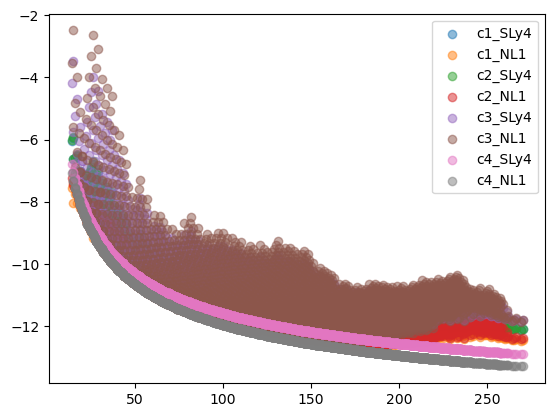

In [239]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

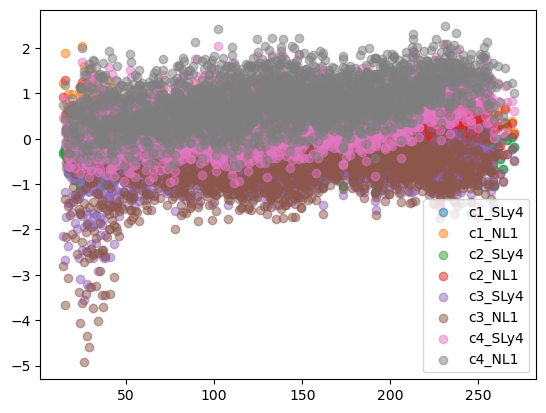

In [240]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y =masses_truth.values -  models_output_df[key].values, label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [241]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.to_latex())

              mean       std  res_mean   res_std      rmse
c1_SLy4 -11.136117  0.997681 -0.138479  0.340072  0.367186
c1_NL1  -11.557858  0.906293  0.283262  0.350907  0.450969
c2_SLy4 -11.130510  1.000848 -0.144085  0.340962  0.370156
c2_NL1  -11.499792  0.933992  0.225196  0.338851  0.406857
c3_SLy4 -10.813755  1.168409 -0.460840  0.465186  0.654807
c3_NL1  -10.854550  1.301794 -0.420046  0.632991  0.759681
c4_SLy4 -11.731693  1.049045  0.457098  0.517888  0.690758
c4_NL1  -12.101409  1.067444  0.826813  0.524817  0.979313
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4 & -11.136117 & 0.997681 & -0.138479 & 0.340072 & 0.367186 \\
c1_NL1 & -11.557858 & 0.906293 & 0.283262 & 0.350907 & 0.450969 \\
c2_SLy4 & -11.130510 & 1.000848 & -0.144085 & 0.340962 & 0.370156 \\
c2_NL1 & -11.499792 & 0.933992 & 0.225196 & 0.338851 & 0.406857 \\
c3_SLy4 & -10.813755 & 1.168409 & -0.460840 & 0.465186 & 0.654807 \\
c3_NL1 & -10.854550 & 1.301794 & -0.420046 & 0.632991 & 0.7

## Version 1.0 - Simple models

In [28]:
#Noise level we will use to "wiggle" all the model predictions a bit
corruption_noise_Mass=10

# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()


masses_truth = Truth([input_NZ["Z"], input_NZ["N"]])
masses_distorted = LDM_quadratic_bias(LDM_truth_params,[input_NZ["Z"], input_NZ["N"]], a = 0.5)

# Model class 1: truth + noise
n_class_1 = 2
models_output = {}
for i in range(n_class_1):
    models_output["c1_" + str(i)] = masses_truth + np.random.randn(len(masses_truth)) * corruption_noise_Mass

# Model class 2: truth + quadratic distortion + noise
n_class_2 = 2
for i in range(n_class_2):
    models_output["c2_" + str(i)] = masses_distorted + np.random.randn(len(masses_truth)) * corruption_noise_Mass

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

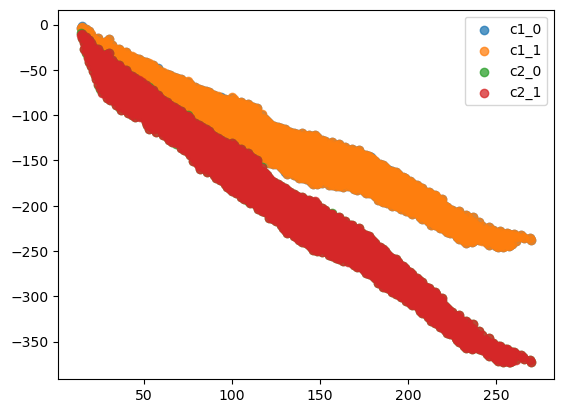

In [29]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.75)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [154]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.to_latex())

              mean           std      res_mean      res_std          rmse
c1_0 -21994.637663  16178.552902     32.361591  1000.487147   1001.010392
c1_1 -21995.497498  16164.763417     33.221426   993.920921    994.475973
c2_0 -33172.758374  24823.447037  11210.482302  8723.554033  14204.763582
c2_1 -33180.422268  24855.947587  11218.146196  8755.622354  14230.520963
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_0 & -21994.637663 & 16178.552902 & 32.361591 & 1000.487147 & 1001.010392 \\
c1_1 & -21995.497498 & 16164.763417 & 33.221426 & 993.920921 & 994.475973 \\
c2_0 & -33172.758374 & 24823.447037 & 11210.482302 & 8723.554033 & 14204.763582 \\
c2_1 & -33180.422268 & 24855.947587 & 11218.146196 & 8755.622354 & 14230.520963 \\
\end{tabular}



## PCA - model output is not standardized

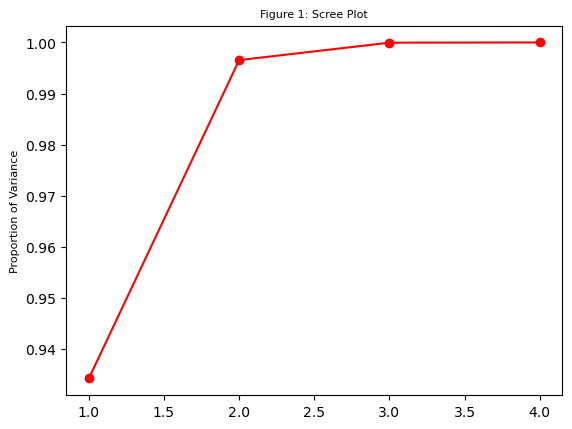

In [243]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(models_output_df[models_output.keys()])

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

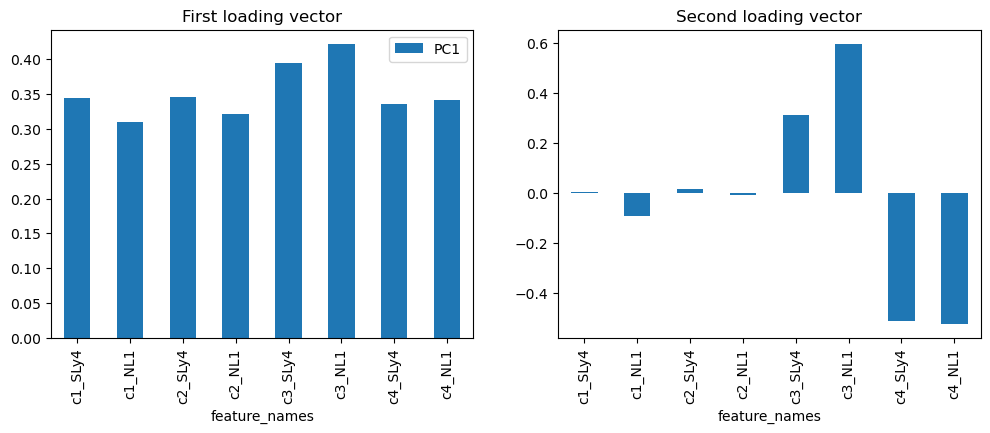

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_SLy4        0.344162  0.006452 -0.117422  0.135029
c1_NL1         0.309525 -0.092799 -0.616512 -0.712430
c2_SLy4        0.345248  0.014782 -0.107008  0.263174
c2_NL1         0.320770 -0.006515 -0.508652  0.614805
c3_SLy4        0.394683  0.311511  0.279172 -0.098367
c3_NL1         0.421472  0.597932  0.278011 -0.121667
c4_SLy4        0.336342 -0.513346  0.297825 -0.034965
c4_NL1         0.342226 -0.522493  0.303347 -0.035547


In [244]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

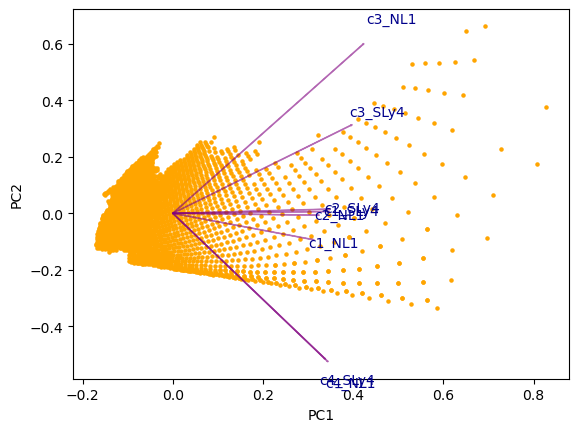

In [245]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))
plt.savefig("Biplot_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

## PCA - model output is standardized

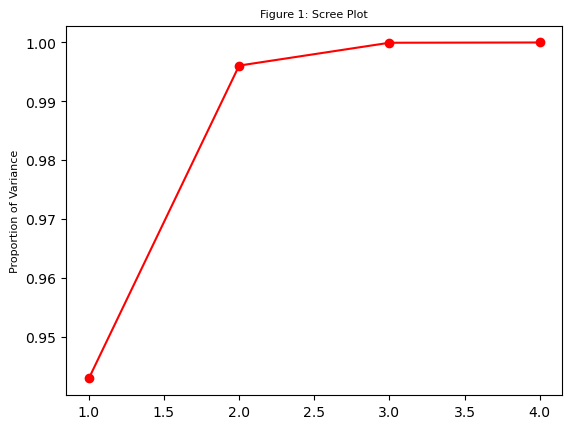

In [246]:
pca = PCA(n_components=4)
X_scaled = StandardScaler().fit_transform(models_output_df[models_output.keys()])
X_pca = pca.fit_transform(X_scaled)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

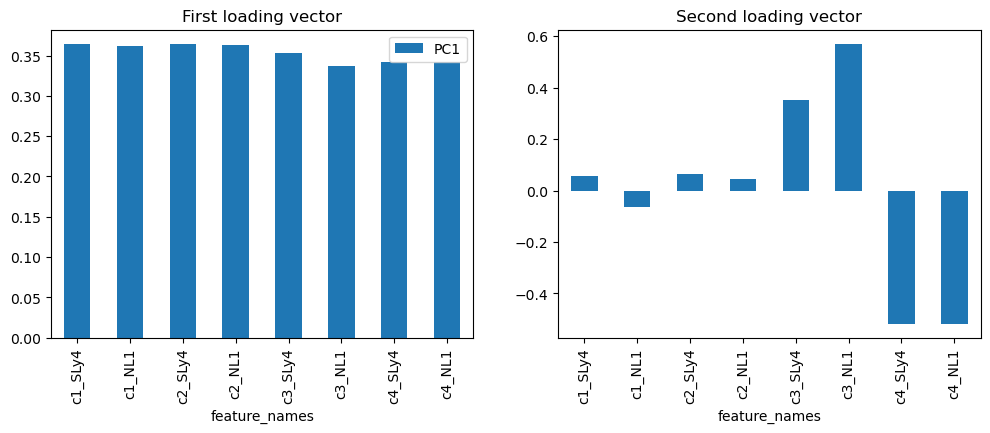

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_SLy4        0.363829  0.056834 -0.049300  0.121900
c1_NL1         0.361556 -0.065244 -0.619558 -0.688937
c2_SLy4        0.363742  0.066298 -0.037731  0.239691
c2_NL1         0.362643  0.043724 -0.474520  0.643098
c3_SLy4        0.353749  0.352070  0.327108 -0.127032
c3_NL1         0.337286  0.571236  0.316699 -0.146239
c4_SLy4        0.342196 -0.517580  0.299724 -0.031293
c4_NL1         0.342182 -0.517738  0.299987 -0.031247


In [247]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

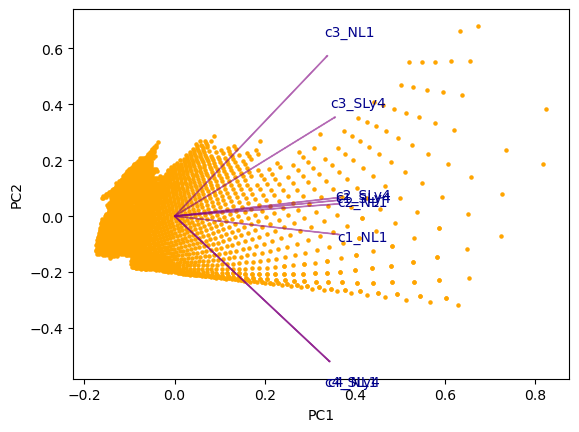

In [248]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

## PCA on residuals - residuals are not standardized

In [249]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 
np.corrcoef(residuals.T)

array([[ 1.        ,  0.90224169,  0.99975618,  0.95899364,  0.80182435,
         0.61672571,  0.64394508,  0.64159561],
       [ 0.90224169,  1.        ,  0.89405073,  0.97474823,  0.49758584,
         0.28569395,  0.71686642,  0.7063752 ],
       [ 0.99975618,  0.89405073,  1.        ,  0.95558676,  0.81407043,
         0.63296704,  0.63039925,  0.62828371],
       [ 0.95899364,  0.97474823,  0.95558676,  1.        ,  0.66471931,
         0.48189316,  0.61870964,  0.61021919],
       [ 0.80182435,  0.49758584,  0.81407043,  0.66471931,  1.        ,
         0.95961322,  0.15605516,  0.16259321],
       [ 0.61672571,  0.28569395,  0.63296704,  0.48189316,  0.95961322,
         1.        , -0.12688504, -0.11932124],
       [ 0.64394508,  0.71686642,  0.63039925,  0.61870964,  0.15605516,
        -0.12688504,  1.        ,  0.99946543],
       [ 0.64159561,  0.7063752 ,  0.62828371,  0.61021919,  0.16259321,
        -0.11932124,  0.99946543,  1.        ]])

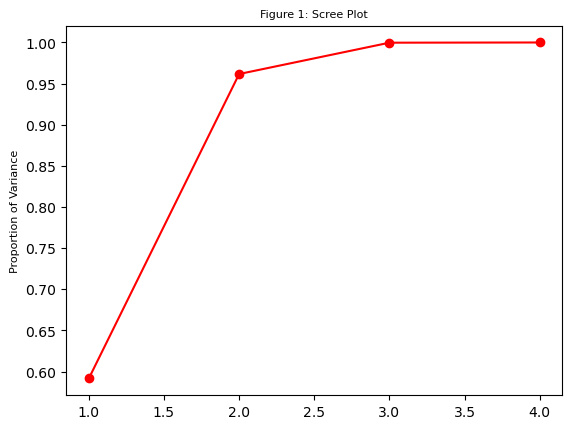

In [250]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(residuals)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_ToyResid_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

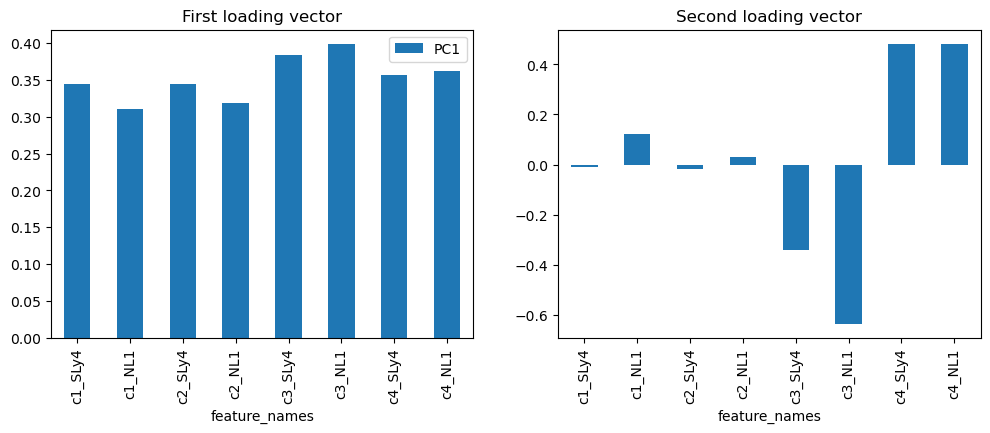

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_SLy4        0.344065 -0.007765  0.147234 -0.295511
c1_NL1         0.310108  0.120740  0.586584  0.680002
c2_SLy4        0.344960 -0.016606  0.139275 -0.395711
c2_NL1         0.319382  0.029166  0.504143 -0.357805
c3_SLy4        0.383711 -0.342718 -0.236860 -0.078622
c3_NL1         0.398319 -0.635136 -0.262058  0.288118
c4_SLy4        0.357023  0.480127 -0.315682 -0.101314
c4_NL1         0.362067  0.482556 -0.369123  0.257295


In [251]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_ToyResid_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

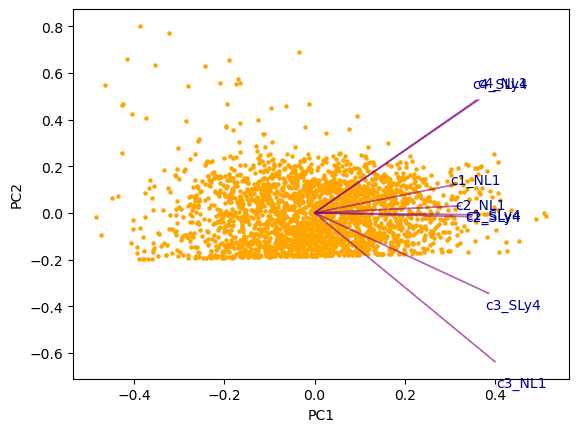

In [252]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_ToyResid_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

## PCA on residuals - residuals are standardized

In [253]:
residuals =masses_truth.values[:,None] - models_output_df[models_output.keys()].values
np.corrcoef(residuals.T)

array([[ 1.        ,  0.90224169,  0.99975618,  0.95899364,  0.80182435,
         0.61672571,  0.64394508,  0.64159561],
       [ 0.90224169,  1.        ,  0.89405073,  0.97474823,  0.49758584,
         0.28569395,  0.71686642,  0.7063752 ],
       [ 0.99975618,  0.89405073,  1.        ,  0.95558676,  0.81407043,
         0.63296704,  0.63039925,  0.62828371],
       [ 0.95899364,  0.97474823,  0.95558676,  1.        ,  0.66471931,
         0.48189316,  0.61870964,  0.61021919],
       [ 0.80182435,  0.49758584,  0.81407043,  0.66471931,  1.        ,
         0.95961322,  0.15605516,  0.16259321],
       [ 0.61672571,  0.28569395,  0.63296704,  0.48189316,  0.95961322,
         1.        , -0.12688504, -0.11932124],
       [ 0.64394508,  0.71686642,  0.63039925,  0.61870964,  0.15605516,
        -0.12688504,  1.        ,  0.99946543],
       [ 0.64159561,  0.7063752 ,  0.62828371,  0.61021919,  0.16259321,
        -0.11932124,  0.99946543,  1.        ]])

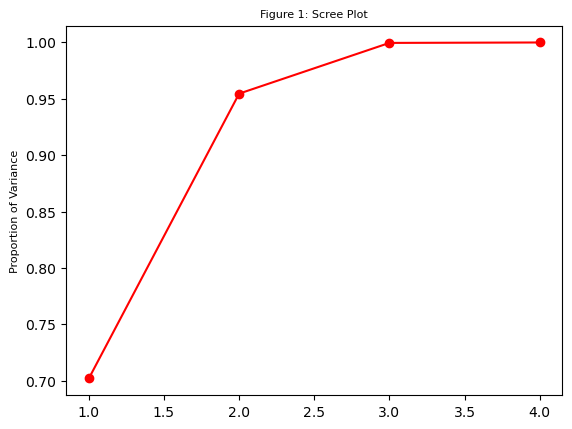

In [254]:
pca = PCA(n_components=4)
X_scaled = StandardScaler().fit_transform(residuals)
X_pca = pca.fit_transform(X_scaled)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

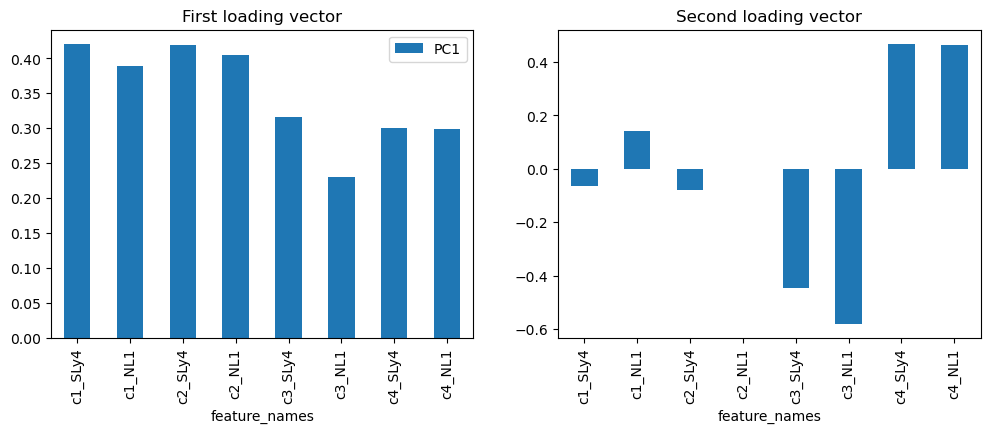

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_SLy4        0.420109 -0.065076  0.013048 -0.214580
c1_NL1         0.389512  0.142918  0.540611  0.714034
c2_SLy4        0.419216 -0.079211  0.003303 -0.329887
c2_NL1         0.405492 -0.001079  0.458640 -0.468104
c3_SLy4        0.315743 -0.445039 -0.333035  0.109461
c3_NL1         0.229753 -0.579896 -0.256667  0.275251
c4_SLy4        0.299784  0.468312 -0.380710 -0.024973
c4_NL1         0.298786  0.464121 -0.418900  0.166721


In [255]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

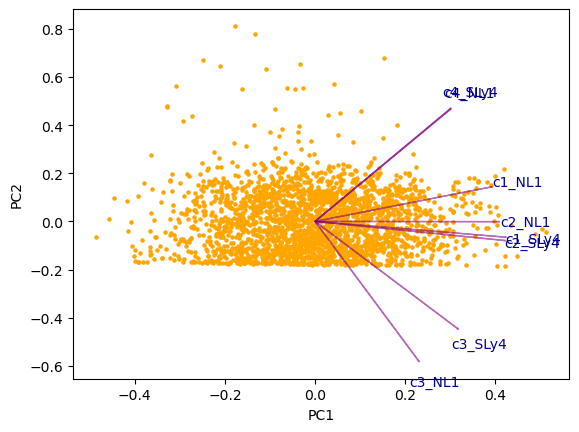

In [256]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()